In [22]:
import pandas as pd
from scipy.optimize import basinhopping
import numpy as np
from validation.TensileExperimental import TensileExperimental

In [23]:
r = TensileExperimental()

df       = r["df"]
df_stats = r["df_stats"]

In [24]:
df_stats.round(2)

Modulo (GPa)       Espesor (mm)             layers v [X,SX,Y,SY] ni
             mean   std         mean   std                              
Name                                                                    
TFP1         2.89  0.23         5.27  0.06          [Y]  [0, 0, 1, 0]  1
TFP2         2.26  0.07         4.70  0.00       [Y, X]  [1, 0, 1, 0]  2
TFP3         2.00  0.00         4.83  0.06      [Y, SX]  [0, 1, 1, 0]  2
TFP4         2.45  0.11         4.70  0.00      [Y, SY]  [0, 0, 1, 1]  2
TFP5         1.63  0.12         5.70  0.00  [Y, SX, SY]  [0, 1, 1, 1]  3
TFP6         1.74  0.07         5.60  0.00   [Y, X, SY]  [1, 0, 1, 1]  3

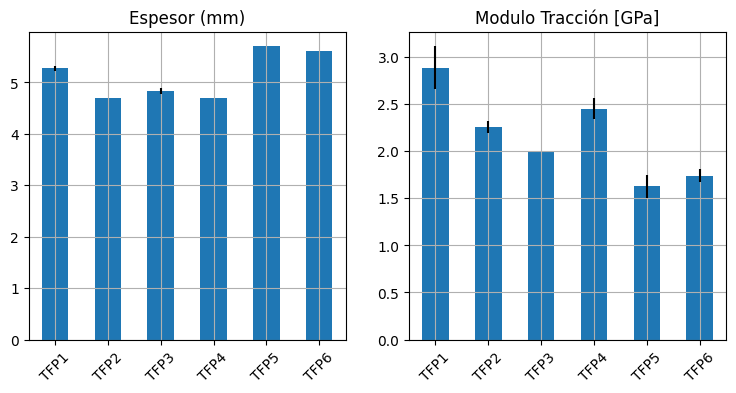

In [25]:
from validation.TensileExperimental import TensilePlotData

TensilePlotData(df_stats)

In [26]:
df_stats

Modulo (GPa)           Espesor (mm)                 layers v [X,SX,Y,SY]  \
             mean       std         mean       std                              
Name                                                                            
TFP1     2.885509  0.227295     5.266667  0.057735          [Y]  [0, 0, 1, 0]   
TFP2     2.258503  0.065626     4.700000  0.000000       [Y, X]  [1, 0, 1, 0]   
TFP3     2.000437  0.004435     4.833333  0.057735      [Y, SX]  [0, 1, 1, 0]   
TFP4     2.451362  0.114353     4.700000  0.000000      [Y, SY]  [0, 0, 1, 1]   
TFP5     1.626582  0.120272     5.700000  0.000000  [Y, SX, SY]  [0, 1, 1, 1]   
TFP6     1.739870  0.067515     5.600000  0.000000   [Y, X, SY]  [1, 0, 1, 1]   

     ni  
         
Name     
TFP1  1  
TFP2  2  
TFP3  2  
TFP4  2  
TFP5  3  
TFP6  3

In [27]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["Espesor (mm)"]["mean"].values

tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

In [28]:
from validation.experimental import manual_data

t_nucleo_exp = manual_data()["t_nucleo [mm]"]

In [29]:
# min square error

def objective(tn,tl):
    return sum((tau_pred_fcn(tn,tl) - tau_exp)**2)

x0 = [0,0]
#
x0 = 2*np.random.rand(2)

bound  = [(0.95*t_nucleo_exp, t_nucleo_exp*1.05), # tn
          (0, None)] # tl



minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bound}

res = basinhopping(lambda x: objective(*x), x0, 
                   minimizer_kwargs=minimizer_kwargs,
                   niter=10)

tn_opt = res.x[0]
tl_opt = res.x[1]

tau_pred = tau_pred_fcn(tn_opt,tl_opt)


In [30]:
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)
print("Residuals: ", res.fun)

Optimal tn:  2.9337
Optimal tl:  0.47572956687980983
Residuals:  1.989033693799284


In [31]:
# Tau predicted
print("Tau predicted: ", tau_pred)
print("Tau experimental: ", tau_exp)

df_exp = pd.DataFrame({"tau_exp": tau_exp, "tau_pred": tau_pred})
df_exp["error [%]"] = 100*abs(df_exp["tau_exp"] - df_exp["tau_pred"]) / df_exp["tau_exp"]
# round to 2 decimals
df_exp = df_exp.round(2)
df_exp

Tau predicted:  [3.88515913 4.83661827 4.83661827 4.83661827 5.7880774  5.7880774 ]
Tau experimental:  [5.26666667 4.7        4.83333333 4.7        5.7        5.6       ]


,tau_exp,tau_pred,error [%]
0,5.27,3.89,26.23
1,4.70,4.84,2.91
2,4.83,4.84,0.07
3,4.70,4.84,2.91
4,5.70,5.79,1.55
5,5.60,5.79,3.36


In [32]:
def E_effective_j(En,Evec,j):
    
    delta_j  = df_stats["v [X,SX,Y,SY]"].iloc[j]
    tau_j    = tau_pred[j]

    return (En*tn_opt + 2*tl_opt*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec):
    return np.array([E_effective_j(En,Evec,j) for j in range(len(df_stats))])


In [33]:
from validation.experimental import  nucleo
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [34]:
def theta(x):
    return 0.5*(np.sign(x)+1)

relu = lambda x: x*theta(x)

In [35]:
# minimize 
E_eff_exp = df_stats["Modulo (GPa)"]["mean"].values

def objective_E(En,Evec):
    Loss_E   = sum((E_effective(En,Evec) - E_eff_exp)**2)

    Emax = np.max(Evec)
    lag_mult = 1e6*relu( En - Emax) # Asumimos que el nucleo es el material más blando que la capas E[0] -> X

    return Loss_E + lag_mult

x0 = np.random.rand(5)
# 
# bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
#             (0.100,None), # Evec[0]   # X
#             (0.100,None), # Evec[1]   # Y
#             (0.100,None), # Evec[2]   # SX
#             (0.100,None), # Evec[3]   # SY
#             (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
#             (0.25,2)  # tl
#             ]

# must be positive
bounds = [(0,None)]*5
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds}

res = basinhopping(lambda x: objective_E(x[0],x[1:]),
                x0, minimizer_kwargs=minimizer_kwargs,
                niter=50)

En_opt = res.x[0]
Evec_opt = res.x[1:]


E_eff_pred = E_effective(En_opt,Evec_opt)

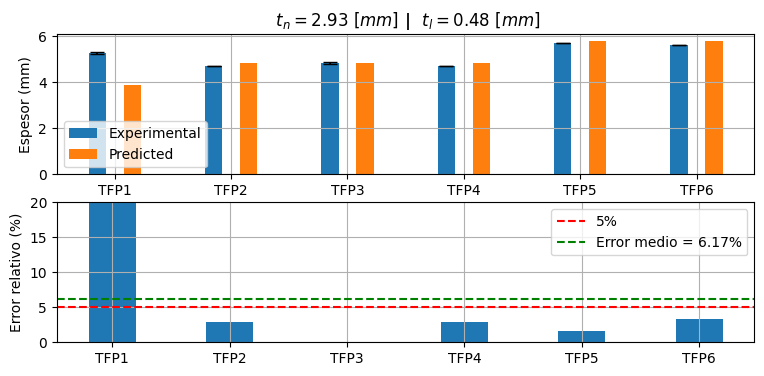

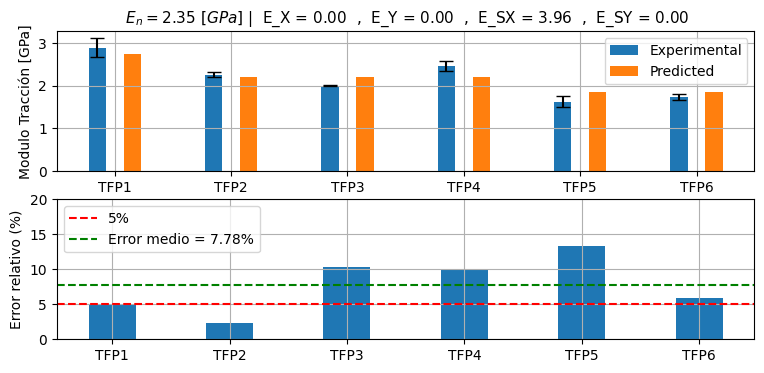

In [36]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [37]:
print("Optimal En: ", En_opt)
print("Optimal Evec: ", Evec_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  2.3513793777833274
Optimal Evec:  [0.         0.         3.96206179 0.        ]
Optimal tn:  2.9337
Optimal tl:  0.47572956687980983


In [38]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,0.00
SX,0.00
Y,3.96
SY,0.00
Nucleo,2.35


In [39]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.93
Capas,0.48


In [40]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP1,2.75,2.89,4.84,3.89,5.27,26.23
1,TFP2,2.21,2.26,2.34,4.84,4.70,2.91
2,TFP3,2.21,2.00,10.26,4.84,4.83,0.07
3,TFP4,2.21,2.45,10.02,4.84,4.70,2.91
4,TFP5,1.84,1.63,13.31,5.79,5.70,1.55


In [41]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_fix_thin.json")